## Calibration using OPENCV

#### Calibrate Mono Camera

Found 38 images in media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3

Calibrating camera...
Processing 38 images...
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_0.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_30.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_32.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_37.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_6.jpg
Successfully found corners in 33 out of 38 images
Mean reprojection error: 0.059062 pixels

Camera matrix:
 [[1.06936178e+03 0.00000000e+00 5.55299273e+02]
 [0.00000000e+00 1.06969222e+03 9.44910636e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients: [-1.99776871e+01  1.00589620e+02 -2.71777936e-04 -

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_4235/1057652585.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors],


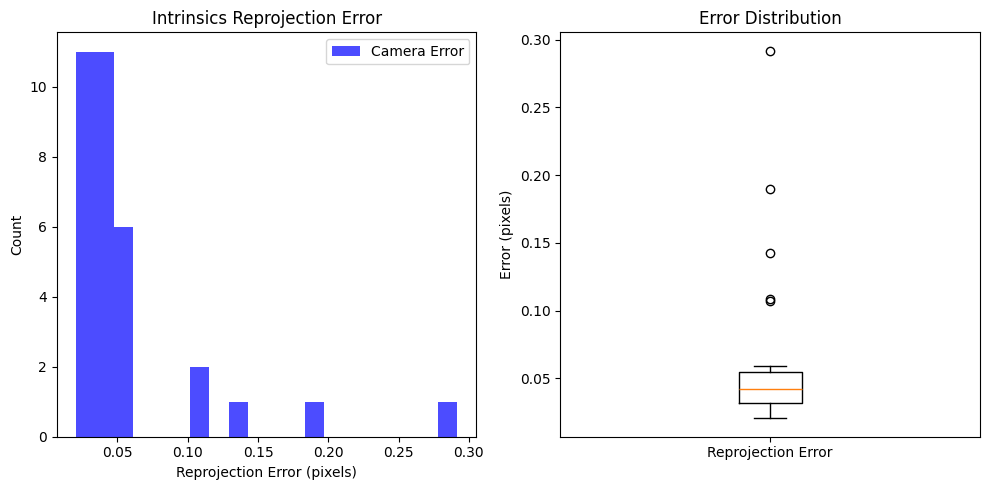

In [8]:
import cv2
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt


def compute_calibration_errors(objpoints, imgpoints, mtx, dist, rvecs, tvecs):
    """
    Compute reprojection error for camera intrinsics calibration
    Returns mean error and per-image errors
    """
    total_error = 0
    errors = []

    for i in range(len(objpoints)):
        # Project 3D points to image plane
        projected_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)

        # Calculate error
        error = cv2.norm(imgpoints[i], projected_points, cv2.NORM_L2) / len(projected_points)
        errors.append(error)
        total_error += error

    mean_error = total_error / len(objpoints)
    return mean_error, errors

def plot_calibration_errors(errors):
    """Plot calibration error distributions"""
    plt.figure(figsize=(10, 5))

    # Intrinsics reprojection error histogram
    plt.subplot(121)
    plt.hist(errors, bins=20, alpha=0.7, label='Camera Error', color='blue')
    plt.xlabel('Reprojection Error (pixels)')
    plt.ylabel('Count')
    plt.title('Intrinsics Reprojection Error')
    plt.legend()

    # Box plot for reprojection error
    plt.subplot(122)
    plt.boxplot([errors],
                labels=['Reprojection Error'])
    plt.ylabel('Error (pixels)')
    plt.title('Error Distribution')

    plt.tight_layout()
    plt.show()

def calibrate_camera(images_path, board_size=(5,7), debug=False):
    """Calibrate a single camera using checkerboard images"""
    objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    # Find both .jpg and .jpeg files
    image_files = sorted(glob.glob(str(images_path / '*.jpg'))) + sorted(glob.glob(str(images_path / '*.jpeg')))
    valid_images = []

    print(f"Processing {len(image_files)} images...")

    image_shape = None # To store the shape of the first valid grayscale image

    for idx, fname in enumerate(image_files):
        img = cv2.imread(fname)
        if img is None:
            print(f"Failed to read image: {fname}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if image_shape is None:
            image_shape = gray.shape[::-1] # Get width, height

        ret, corners = cv2.findChessboardCorners(gray, board_size, None)

        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
                                      (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            imgpoints.append(corners2)
            valid_images.append(fname)
        else:
            print(f"Failed to find corners in image: {fname}")

    if len(objpoints) < 10:
        raise ValueError(f"Too few valid images ({len(objpoints)}) found with corners. Need at least 10 for good calibration.")

    print(f"Successfully found corners in {len(objpoints)} out of {len(image_files)} images")

    if image_shape is None:
         raise ValueError("No valid images were successfully processed to determine image size.")

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, image_shape, None, None,
        flags=cv2.CALIB_RATIONAL_MODEL)

    # Calculate reprojection error
    mean_error, errors = compute_calibration_errors(objpoints, imgpoints, mtx, dist, rvecs, tvecs)

    print(f"Mean reprojection error: {mean_error:.6f} pixels")

    return mtx, dist, objpoints, imgpoints, rvecs, tvecs, valid_images, errors

def main():
    # Define the path to the checkerboard images for the single camera
    path = Path("media/checkerboards/Meta Rayban/left eye checkerboard 5x7")
    # path = Path("media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3")
    # Define a relative path for saving results within the workspace
    save_path = Path("media/camera_intrinsics_extrinsics/Meta Rayban")

    # Verify image path exists
    if not path.exists():
        raise ValueError(f"Checkerboard image directory not found: {path}")

    # Find both .jpg and .jpeg files
    image_files = sorted(glob.glob(str(path / '*.jpg'))) + sorted(glob.glob(str(path / '*.jpeg')))
    print(f"Found {len(image_files)} images in {path}")

    if not image_files:
         raise ValueError(f"No .jpg or .jpeg images found in {path}")

    # Calibrate camera
    print("\nCalibrating camera...")
    # Specify the board size directly if it's not the default (5,7)
    board_width = 5
    board_height = 7
    mtx, dist, objpoints, imgpoints, rvecs, tvecs, valid_images, errors = calibrate_camera(path, board_size=(board_width, board_height))

    # Save camera matrix and distortion coefficients
    # Create the target directory (and any parent directories) if it doesn't exist
    save_path.mkdir(parents=True, exist_ok=True) # Changed from save_path.parent...

    np.save(save_path / "camera_intrinsics.npy", mtx)
    np.save(save_path / "distortion_coefficients.npy", dist)
    print(f"Calibration results saved to: {save_path}") # Added confirmation message

    # Print camera matrix and distortion coefficients
    print("\nCamera matrix:\n", mtx)
    print("Distortion coefficients:", dist.ravel())

    # Print detailed error stats
    print("\nCalibration Results:")
    print(f"Mean reprojection error: {np.mean(errors):.6f} pixels")
    print(f"Min reprojection error: {np.min(errors):.6f} pixels")
    print(f"Max reprojection error: {np.max(errors):.6f} pixels")

    # Plot error distribution
    plot_calibration_errors(errors)

if __name__ == "__main__":
    main()


#### Calibrate Stereo Camera

Found 38 left images and 38 right images

Calibrating left camera...
Processing 38 images...
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_0.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_30.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_32.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_37.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3/PHOTO_6.jpg
Successfully processed 33 out of 38 images
Initial mean reprojection error: 0.059062

Calibrating right camera...
Processing 38 images...
Failed to find corners in image: media/checkerboards/OMGlasses/right eye checkerboard 5x7 B14 R3/PHOTO_0.jpg
Failed to find corners in image: media/checkerboards/OMGlasses/right eye checkerboard 5x7 B14 R3/PHOTO_28.jpg
Failed 

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_4235/3777104695.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([left_errors, right_errors, epipolar_errors],


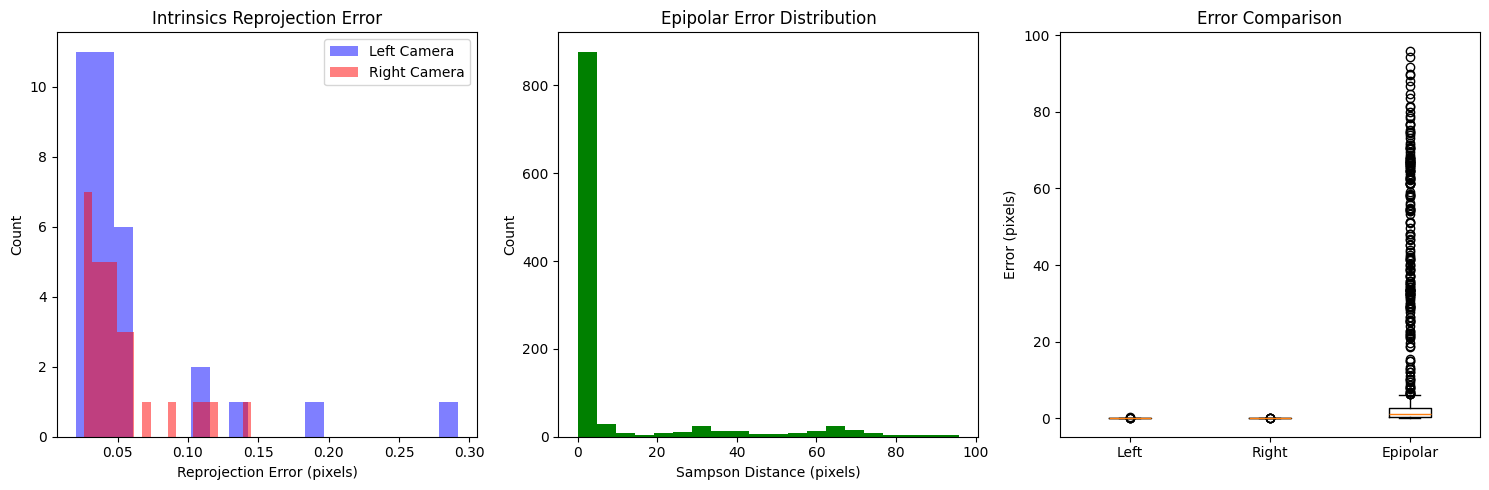

In [7]:
import cv2
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt

def compute_disparity(left_img_path, right_img_path):
    """Compute disparity map using SGBM"""
    # Read images
    left_img = cv2.imread(left_img_path)
    right_img = cv2.imread(right_img_path)
    
    # Convert to grayscale
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    
    # Create SGBM matcher
    window_size = 3
    min_disp = 0
    num_disp = 160
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size**2,
        P2=32 * 3 * window_size**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )
    
    # Compute disparity
    disparity = stereo.compute(left_gray, right_gray)
    
    # Normalize disparity for visualization
    disparity = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return disparity

def compute_calibration_errors(objpoints, imgpoints, mtx, dist, rvecs, tvecs):
    """
    Compute reprojection error for camera intrinsics calibration
    Returns mean error and per-image errors
    """
    total_error = 0
    errors = []
    
    for i in range(len(objpoints)):
        # Project 3D points to image plane
        projected_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        
        # Calculate error
        error = cv2.norm(imgpoints[i], projected_points, cv2.NORM_L2) / len(projected_points)
        errors.append(error)
        total_error += error
        
    mean_error = total_error / len(objpoints)
    return mean_error, errors

def compute_epipolar_error(left_imgpoints, right_imgpoints, F):
    """
    Compute epipolar alignment error using Sampson distance
    Returns mean error and per-point errors
    """
    total_error = 0
    errors = []
    
    for left_points, right_points in zip(left_imgpoints, right_imgpoints):
        # Convert points to homogeneous coordinates
        left_points = left_points.reshape(-1, 2)
        right_points = right_points.reshape(-1, 2)
        
        left_homog = np.column_stack((left_points, np.ones(len(left_points))))
        right_homog = np.column_stack((right_points, np.ones(len(right_points))))
        
        # Compute Sampson distance for each point pair
        for left_pt, right_pt in zip(left_homog, right_homog):
            # Calculate terms for Sampson distance
            Fx = np.dot(F, left_pt)
            Ftx = np.dot(F.T, right_pt)
            
            # Sampson distance
            numerator = (np.dot(right_pt, np.dot(F, left_pt)))**2
            denominator = Fx[0]**2 + Fx[1]**2 + Ftx[0]**2 + Ftx[1]**2
            
            error = numerator / denominator
            errors.append(np.sqrt(error))
            total_error += error
    
    mean_error = np.mean(errors)
    return mean_error, errors

def plot_calibration_errors(left_errors, right_errors, epipolar_errors):
    """Plot calibration error distributions"""
    plt.figure(figsize=(15, 5))
    
    # Intrinsics reprojection error
    plt.subplot(131)
    plt.hist(left_errors, bins=20, alpha=0.5, label='Left Camera', color='blue')
    plt.hist(right_errors, bins=20, alpha=0.5, label='Right Camera', color='red')
    plt.xlabel('Reprojection Error (pixels)')
    plt.ylabel('Count')
    plt.title('Intrinsics Reprojection Error')
    plt.legend()
    
    # Epipolar error
    plt.subplot(132)
    plt.hist(epipolar_errors, bins=20, color='green')
    plt.xlabel('Sampson Distance (pixels)')
    plt.ylabel('Count')
    plt.title('Epipolar Error Distribution')
    
    # Box plot for comparison
    plt.subplot(133)
    plt.boxplot([left_errors, right_errors, epipolar_errors], 
                labels=['Left', 'Right', 'Epipolar'])
    plt.ylabel('Error (pixels)')
    plt.title('Error Comparison')
    
    plt.tight_layout()
    plt.show()

def calibrate_single_camera(images_path, board_size=(5,7), debug=False):
    """Calibrate a single camera using checkerboard images"""
    objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    images = sorted(glob.glob(str(images_path / '*.jpg')))
    valid_images = []
    
    print(f"Processing {len(images)} images...")
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        if img is None:
            print(f"Failed to read image: {fname}")
            continue
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, board_size, None)
        
        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
                                      (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            imgpoints.append(corners2)
            valid_images.append(fname)
        else:
            print(f"Failed to find corners in image: {fname}")
    
    if len(objpoints) < 10:
        raise ValueError(f"Too few valid images ({len(objpoints)}). Need at least 10 for good calibration.")
    
    print(f"Successfully processed {len(objpoints)} out of {len(images)} images")
    
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None,
        flags=cv2.CALIB_RATIONAL_MODEL)
    
    # Calculate initial reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    
    print(f"Initial mean reprojection error: {mean_error/len(objpoints):.6f}")
    
    return mtx, dist, objpoints, imgpoints, rvecs, tvecs, valid_images

def stereo_calibrate(left_path, right_path, left_mtx, left_dist, right_mtx, right_dist, board_size=(5,7)):
    """Calibrate stereo camera setup"""
    objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1,2)
    
    objpoints = []
    left_imgpoints = []
    right_imgpoints = []
    
    left_images = sorted(glob.glob(str(left_path / '*.jpg')))
    right_images = sorted(glob.glob(str(right_path / '*.jpg')))
    
    if len(left_images) != len(right_images):
        raise ValueError("Number of left and right images must match")
    
    print(f"Processing {len(left_images)} stereo pairs...")
    
    for left_fname, right_fname in zip(left_images, right_images):
        left_img = cv2.imread(left_fname)
        right_img = cv2.imread(right_fname)
        
        if left_img is None or right_img is None:
            print(f"Failed to read images: {left_fname} or {right_fname}")
            continue
            
        left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
        
        left_ret, left_corners = cv2.findChessboardCorners(left_gray, board_size, None)
        right_ret, right_corners = cv2.findChessboardCorners(right_gray, board_size, None)
        
        if left_ret and right_ret:
            objpoints.append(objp)
            
            left_corners2 = cv2.cornerSubPix(left_gray, left_corners, (11,11), (-1,-1),
                                           (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            right_corners2 = cv2.cornerSubPix(right_gray, right_corners, (11,11), (-1,-1),
                                            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            
            left_imgpoints.append(left_corners2)
            right_imgpoints.append(right_corners2)
    
    if len(objpoints) < 10:
        raise ValueError(f"Too few valid stereo pairs ({len(objpoints)}). Need at least 10.")
    
    print(f"Using {len(objpoints)} valid stereo pairs for calibration")
    
    # Stereo calibration with better flags
    flags = (cv2.CALIB_FIX_INTRINSIC + 
            cv2.CALIB_USE_INTRINSIC_GUESS +
            cv2.CALIB_RATIONAL_MODEL)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
    
    ret, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objpoints, left_imgpoints, right_imgpoints,
        left_mtx, left_dist, right_mtx, right_dist,
        left_gray.shape[::-1], criteria=criteria, flags=flags)
    
    print(f"Stereo calibration RMS error: {ret}")
    
    return R, T, E, F, objpoints, left_imgpoints, right_imgpoints

def main():
    left_path = Path("media/checkerboards/OMGlasses/left eye checkerboard 5x7 B14 R3")
    right_path = Path("media/checkerboards/OMGlasses/right eye checkerboard 5x7 B14 R3")
    # Use the specified absolute save path
    save_path_dir = Path("/Users/hendrik/OMGrab/media/camera_intrinsics_extrinsics/OMGlasses")

    # Verify image paths exist
    if not left_path.exists() or not right_path.exists():
        raise ValueError(f"Checkerboard image directories not found. Checked: {left_path} and {right_path}")

    # Print number of images found
    left_images = sorted(glob.glob(str(left_path / '*.jpg'))) + sorted(glob.glob(str(left_path / '*.jpeg')))
    right_images = sorted(glob.glob(str(right_path / '*.jpg'))) + sorted(glob.glob(str(right_path / '*.jpeg')))
    print(f"Found {len(left_images)} left images and {len(right_images)} right images")
    if not left_images or not right_images:
        raise ValueError("No images found in one or both directories.")
    if len(left_images) != len(right_images):
         print(f"Warning: Number of left ({len(left_images)}) and right ({len(right_images)}) images does not match. Calibration might use fewer pairs.")

    # Calibrate individual cameras
    print("\nCalibrating left camera...")
    left_mtx, left_dist, left_objpoints, left_imgpoints, left_rvecs, left_tvecs, left_valid = calibrate_single_camera(left_path, board_size=(5,7))

    print("\nCalibrating right camera...")
    right_mtx, right_dist, right_objpoints, right_imgpoints, right_rvecs, right_tvecs, right_valid = calibrate_single_camera(right_path, board_size=(5,7))

    # Print camera matrices and distortion coefficients
    print("\nLeft camera matrix:\n", left_mtx)
    print("Left distortion coefficients:", left_dist.ravel())
    print("\nRight camera matrix:\n", right_mtx)
    print("Right distortion coefficients:", right_dist.ravel())

    # Stereo calibration
    print("\nPerforming stereo calibration...")
    R, T, E, F, stereo_objpoints, stereo_left_imgpoints, stereo_right_imgpoints = stereo_calibrate(
        left_path, right_path, left_mtx, left_dist, right_mtx, right_dist, board_size=(5,7))

    # --- Calculate extrinsic matrices and save results ---
    print("\nCalculating extrinsic matrices...")
    # Left camera extrinsics [I|0] (assuming left camera is the origin)
    left_extrinsics = np.hstack((np.eye(3), np.zeros((3, 1))))
    # Right camera extrinsics [R|T] (relative to left camera)
    right_extrinsics = np.hstack((R, T))

    print(f"Saving calibration results to {save_path_dir}...")
    # Create the directory if it doesn't exist
    save_path_dir.mkdir(parents=True, exist_ok=True)

    # Save parameters as individual .npy files
    np.save(save_path_dir / "left_camera_intrinsics.npy", left_mtx)
    np.save(save_path_dir / "left_distortion_coefficients.npy", left_dist)
    np.save(save_path_dir / "left_camera_extrinsics.npy", left_extrinsics)
    np.save(save_path_dir / "right_camera_intrinsics.npy", right_mtx)
    np.save(save_path_dir / "right_distortion_coefficients.npy", right_dist)
    np.save(save_path_dir / "right_camera_extrinsics.npy", right_extrinsics)

    print(f"Calibration results saved successfully as individual files in {save_path_dir}.")
    # --- End of saving section ---

    # Compute errors
    left_mean_error, left_errors = compute_calibration_errors(
        left_objpoints, left_imgpoints, left_mtx, left_dist, left_rvecs, left_tvecs)
    right_mean_error, right_errors = compute_calibration_errors(
        right_objpoints, right_imgpoints, right_mtx, right_dist, right_rvecs, right_tvecs)

    print("\nCalibration Results:")
    print(f"Left camera reprojection error: {left_mean_error:.6f} pixels")
    print(f"Right camera reprojection error: {right_mean_error:.6f} pixels")

    if stereo_left_imgpoints and stereo_right_imgpoints:
        mean_epipolar_error, epipolar_errors = compute_epipolar_error(
            stereo_left_imgpoints, stereo_right_imgpoints, F)
        print(f"Mean epipolar error: {mean_epipolar_error:.6f} pixels")
        print(f"Min epipolar error: {np.min(epipolar_errors):.6f} pixels")
        print(f"Max epipolar error: {np.max(epipolar_errors):.6f} pixels")

        plot_calibration_errors(left_errors, right_errors, epipolar_errors)
    else:
        print("Could not compute epipolar error: No valid stereo image points found.")


if __name__ == "__main__":
    main()

## Point Cloud Visualization

#### Single image using Depth Anything Metric

Loading Depth Anything V2 model...
Using device: mps
Estimating depth...
Generating point cloud...
Point cloud saved to output_pointcloud.ply
Displaying results...


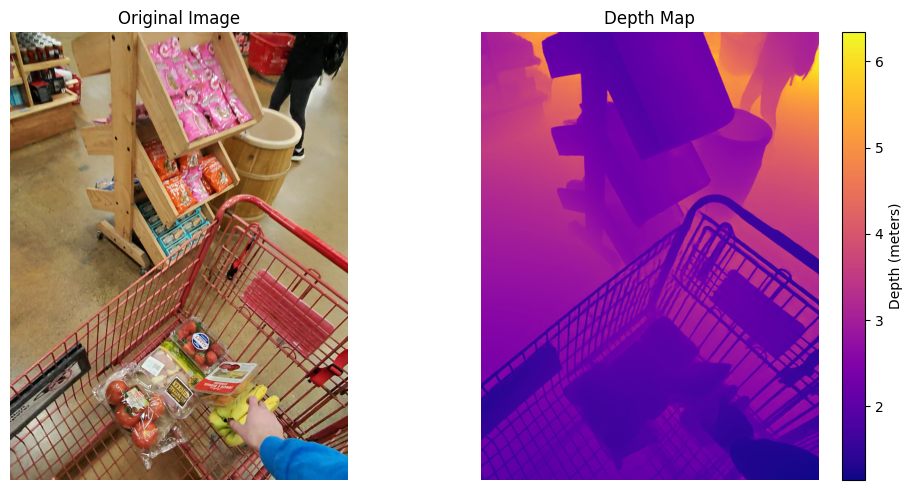


Point Cloud Statistics:
Number of points: 2506625
X range: -2.79 to 0.06 meters
Y range: -4.97 to 0.11 meters
Z range: 1.15 to 6.34 meters


In [8]:
import torch
import numpy as np
import open3d as o3d
from PIL import Image
import cv2
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import matplotlib.pyplot as plt


def get_device():
    """Get the best available device (MPS, CUDA, or CPU)"""
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def rectify_image(image_path, camera_matrix, dist_coeffs):
    """Rectify, undistort, and crop a single image to the maximum valid rectangle."""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image at {image_path}")
        
    h, w = image.shape[:2]
    
    # Get the optimal new camera matrix and region of interest (ROI) with alpha=0
    # alpha=0 means the returned matrix ensures no black pixels are visible after undistortion
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 0, (w,h))
    
    # Undistort the image using the new optimal camera matrix
    undistorted = cv2.undistort(image, camera_matrix, dist_coeffs, None, newcameramtx)

    # Crop the image to the calculated ROI
    x, y, w_roi, h_roi = roi
    cropped_undistorted = undistorted[y:y+h_roi, x:x+w_roi]

    # Convert the *cropped* BGR image to RGB
    cropped_undistorted_rgb = cv2.cvtColor(cropped_undistorted, cv2.COLOR_BGR2RGB)

    return cropped_undistorted_rgb


    
def load_depth_model(model_name="depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf"):
    """Load the Depth Anything V2 model and processor with MPS acceleration"""
    device = get_device()
    print(f"Using device: {device}")
    
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForDepthEstimation.from_pretrained(model_name)
    model = model.to(device)
    model.eval()
    return model, image_processor, device

def estimate_depth(image_path, model, processor, device, camera_matrix, dist_coeffs):
    """Estimate depth from image using Depth Anything V2"""
    # First rectify the image
    image_rgb = rectify_image(image_path, camera_matrix, dist_coeffs)
    
    # Convert to PIL Image
    image_pil = Image.fromarray(image_rgb)

    # Process image for depth estimation
    inputs = processor(images=image_pil, return_tensors="pt")
    
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=(image_rgb.shape[0], image_rgb.shape[1]),
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    # Move back to CPU for numpy conversion
    prediction = prediction.cpu()
    return image_rgb, prediction.numpy()

def create_point_cloud(rgb_image, depth_map, camera_intrinsics):
    """Convert RGB-D to point cloud using camera intrinsics"""
    # Get image dimensions
    height, width = depth_map.shape

    fx = camera_intrinsics[0, 0]
    fy = camera_intrinsics[1, 1]
    cx = camera_intrinsics[0, 2]
    cy = camera_intrinsics[1, 2]

    # Create meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Back-project to 3D
    x_3d = (x - cx) * depth_map / fx
    y_3d = (y - cy) * depth_map / fy
    z_3d = depth_map

    # Stack and reshape to points
    points = np.stack([x_3d, y_3d, z_3d], axis=-1).reshape(-1, 3)
    colors = rgb_image.reshape(-1, 3) / 255.0

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # # Remove invalid points and statistical outliers
    # pcd = pcd.voxel_down_sample(voxel_size=0.01)
    # pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    return pcd

def visualize_results(image, depth_map, point_cloud):
    """Visualize the original image, depth map, and point cloud"""
    # Create subplot
    fig = plt.figure(figsize=(15, 5))
    
    # Original image
    ax = fig.add_subplot(131)
    ax.imshow(image)
    ax.set_title('Original Image')
    ax.axis('off')
    
    # Depth map
    ax = fig.add_subplot(132)
    depth_vis = ax.imshow(depth_map, cmap='plasma')
    ax.set_title('Depth Map')
    ax.axis('off')
    plt.colorbar(depth_vis, ax=ax, label='Depth (meters)')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize point cloud
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)
    o3d.visualization.draw_geometries([point_cloud, coord_frame],
                                    window_name="Metric Point Cloud",
                                    width=1024,
                                    height=768)

def process_batch(image_paths, output_dir, model, processor, device, camera_matrix, dist_coeffs, batch_size=4):
    """Process multiple images in batches"""
    import os
    from tqdm import tqdm
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        for image_path in batch_paths:
            try:
                # Process single image
                image, depth_map = estimate_depth(image_path, model, processor, device, camera_matrix, dist_coeffs)
                point_cloud = create_point_cloud(image, depth_map)
                
                # Save point cloud
                output_path = os.path.join(output_dir, 
                    os.path.splitext(os.path.basename(image_path))[0] + ".ply")
                o3d.io.write_point_cloud(output_path, point_cloud)
                
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

def main():
    # Parameters
    image_path = "media/images/grab_banana.jpg"
    output_path = "output_pointcloud.ply"
    path_distortion = "media/camera_intrinsics_extrinsics/Meta Rayban/distortion_coefficients.npy"
    path_intrinsics = "media/camera_intrinsics_extrinsics/Meta Rayban/camera_intrinsics.npy"

    camera_matrix = np.load(path_intrinsics)
    dist_coeffs = np.load(path_distortion)
    
    # Load model with MPS acceleration
    print("Loading Depth Anything V2 model...")
    model, processor, device = load_depth_model()

    # Process image
    print("Estimating depth...")
    image, depth_map = estimate_depth(image_path, model, processor, device, camera_matrix, dist_coeffs)
    
    # Create point cloud
    print("Generating point cloud...")
    point_cloud = create_point_cloud(image, depth_map, camera_matrix)
    
    # Save point cloud
    o3d.io.write_point_cloud(output_path, point_cloud)
    print(f"Point cloud saved to {output_path}")
    
    # Visualize results
    print("Displaying results...")
    visualize_results(image, depth_map, point_cloud)
    
    # Print statistics
    points = np.asarray(point_cloud.points)
    print("\nPoint Cloud Statistics:")
    print(f"Number of points: {len(points)}")
    print(f"X range: {points[:,0].min():.2f} to {points[:,0].max():.2f} meters")
    print(f"Y range: {points[:,1].min():.2f} to {points[:,1].max():.2f} meters")
    print(f"Z range: {points[:,2].min():.2f} to {points[:,2].max():.2f} meters")

if __name__ == "__main__":
    # For processing a single image
    main()
    
    # For processing multiple images
    # image_paths = glob.glob("path/to/images/*.jpg")
    # output_dir = "path/to/output"
    # model, processor, device = load_depth_model()
    # process_batch(image_paths, output_dir, model, processor, device)

#### Video point cloud Depth Anything Metric

In [115]:
import torch
import numpy as np
import open3d as o3d
import cv2
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from tqdm import tqdm
import os
import glob

# Camera intrinsics
K_meters = np.array([
    [1.06933425e+03, 0.00000000e+00, 5.55076352e+02],
    [0.00000000e+00, 1.06959363e+03, 9.45074567e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def load_depth_model(model_name="depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf"):
    device = get_device()
    print(f"Using device: {device}")
    
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForDepthEstimation.from_pretrained(model_name)
    model = model.to(device)
    model.eval()
    return model, image_processor, device

def estimate_depth(frame, model, processor, device):
    """Estimate depth from video frame"""
    # Convert frame to PIL Image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = processor(images=image, return_tensors="pt")
    
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    return image, prediction.cpu().numpy()

def create_point_cloud(rgb_image, depth_map, camera_intrinsics):
    """Convert RGB-D to point cloud using camera intrinsics"""
    rgb = np.array(rgb_image)
    height, width = depth_map.shape
    
    fx = camera_intrinsics[0, 0]
    fy = camera_intrinsics[1, 1]
    cx = camera_intrinsics[0, 2]
    cy = camera_intrinsics[1, 2]

    # Create meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Back-project to 3D
    x_3d = (x - cx) * depth_map / fx
    y_3d = (y - cy) * depth_map / fy
    z_3d = depth_map

    # Stack and reshape to points
    points = np.stack([x_3d, y_3d, z_3d], axis=-1).reshape(-1, 3)
    colors = rgb.reshape(-1, 3) / 255.0

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Downsample and remove outliers
    pcd = pcd.voxel_down_sample(voxel_size=0.02)
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    return pcd

def process_video(video_path, output_dir):
    """Process video frames and generate point clouds"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load model
    model, processor, device = load_depth_model()
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Process frames
    for frame_idx in tqdm(range(total_frames), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break
            
        # Process frame
        image, depth_map = estimate_depth(frame, model, processor, device)
        point_cloud = create_point_cloud(image, depth_map, K_meters)
        
        # Save point cloud
        output_path = os.path.join(output_dir, f"frame_{frame_idx:05d}.ply")
        o3d.io.write_point_cloud(output_path, point_cloud)
    
    cap.release()

def create_visualization_video(point_clouds_dir, output_video_path, fps=30):
    """Create a video of rotating point clouds from camera perspective"""
    pcd_files = sorted(glob.glob(os.path.join(point_clouds_dir, "*.ply")))
    
    if not pcd_files:
        print("No point cloud files found!")
        return
        
    # Create visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=1000, height=500)
    
    # Set up render options
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    opt.point_size = 4.0
    
    # Load first point cloud to set up view
    first_pcd = o3d.io.read_point_cloud(pcd_files[0])
    
    # Fix orientation: rotate 180 degrees around X-axis
    R = first_pcd.get_rotation_matrix_from_xyz((np.pi, 0, 0))
    first_pcd.rotate(R, center=(0, 0, 0))
    
    vis.add_geometry(first_pcd)
    
    # Set up camera view parameters
    ctr = vis.get_view_control()
    
    # Get camera parameters
    cam = ctr.convert_to_pinhole_camera_parameters()
    
    # Set up front view (camera perspective)
    # Assuming Z is forward, Y is up, X is right
    cam.extrinsic = np.array([
        [1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, -1, 2],  # Adjust the last value (2) to move camera back/forward
        [0, 0, 0, 1]
    ])
    
    ctr.convert_from_pinhole_camera_parameters(cam)
    
    # Adjust zoom level
    ctr.set_zoom(0.1)  # Adjust this value to change zoom level (smaller = more zoom)
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (1920, 1080))
    
    # Process each frame
    rotation_angle = 360.0 / len(pcd_files)  # Complete rotation over all frames
    
    for i, pcd_file in enumerate(tqdm(pcd_files, desc="Creating video")):
        # Load and process point cloud
        pcd = o3d.io.read_point_cloud(pcd_file)
        
        # Apply same orientation fix
        pcd.rotate(R, center=(0, 0, 0))
        
        # Update visualization
        vis.clear_geometries()
        vis.add_geometry(pcd)
        
        # Optional: Add subtle rotation for visualization
        # Comment out these lines if you don't want any rotation
        # if i > 0:
        #     ctr.rotate(rotation_angle * 0.1, 0.0)  # Reduced rotation speed
        
        # Capture frame
        vis.poll_events()
        vis.update_renderer()
        image = vis.capture_screen_float_buffer(False)
        video_frame = np.asarray(image) * 255
        video_frame = cv2.cvtColor(video_frame.astype(np.uint8), cv2.COLOR_RGB2BGR)
        video_writer.write(video_frame)
    
    # Clean up
    vis.destroy_window()
    video_writer.release()
def main():
    video_path = "videos/mono videos/cashier_short (1).mp4"
    output_dir = "point_clouds"
    output_video = "point_cloud_visualization.mp4"
    
    # # Process video frames to point clouds
    # print("Processing video frames...")
    # process_video(video_path, output_dir)
    
    # Create visualization video
    print("Creating visualization video...")
    create_visualization_video(output_dir, output_video)
    
    print("Processing complete!")
    print(f"Point clouds saved in: {output_dir}")
    print(f"Visualization video saved as: {output_video}")

if __name__ == "__main__":
    main()

Creating visualization video...


Creating video:   0%|          | 0/429 [00:00<?, ?it/s]2025-04-08 11:09:17.233 python[29509:6827572] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-08 11:09:17.233 python[29509:6827572] +[IMKInputSession subclass]: chose IMKInputSession_Modern
Creating video: 100%|██████████| 429/429 [00:10<00:00, 41.05it/s]

Processing complete!
Point clouds saved in: point_clouds
Visualization video saved as: point_cloud_visualization.mp4


#### Point cloud from video with person detection

In [ ]:
from ultralytics import YOLO
import torch
import numpy as np
import open3d as o3d
import cv2
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from tqdm import tqdm
import os
import glob

# Camera intrinsics
K_meters = np.array([
    [1.06933425e+03, 0.00000000e+00, 5.55076352e+02],
    [0.00000000e+00, 1.06959363e+03, 9.45074567e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

def load_yolo():
    """Load YOLOv8 model for person detection"""
    model = YOLO('yolov8n.pt')  # Load the smallest YOLOv8 model
    return model

def detect_persons(frame, yolo_model):
    """Detect persons in frame using YOLOv8"""
    results = yolo_model(frame, classes=[0])  # class 0 is person in COCO
    boxes = []
    
    for result in results:
        boxes_data = result.boxes
        for box in boxes_data:
            if box.conf > 0.5:  # Confidence threshold
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                boxes.append((x1, y1, x2, y2))
    
    return boxes

def crop_and_pad_box(frame, box, padding=50):
    """Crop frame to box with padding and maintain aspect ratio"""
    x1, y1, x2, y2 = box
    h, w = frame.shape[:2]
    
    # Add padding
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(w, x2 + padding)
    y2 = min(h, y2 + padding)
    
    return frame[y1:y2, x1:x2], (x1, y1, x2, y2)
def create_point_cloud(rgb_image, depth_map, camera_intrinsics):
    """Convert RGB-D to point cloud using camera intrinsics"""
    # Convert PIL Image to numpy array if needed
    if isinstance(rgb_image, Image.Image):
        rgb = np.array(rgb_image)
    else:
        rgb = rgb_image
        
    height, width = depth_map.shape
    
    fx = camera_intrinsics[0, 0]
    fy = camera_intrinsics[1, 1]
    cx = camera_intrinsics[0, 2]
    cy = camera_intrinsics[1, 2]

    # Create meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Back-project to 3D
    x_3d = (x - cx) * depth_map / fx
    y_3d = (y - cy) * depth_map / fy
    z_3d = depth_map

    # Stack and reshape to points
    points = np.stack([x_3d, y_3d, z_3d], axis=-1).reshape(-1, 3)
    colors = rgb.reshape(-1, 3) / 255.0

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Downsample and remove outliers
    pcd = pcd.voxel_down_sample(voxel_size=0.02)
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    return pcd

def estimate_depth(frame, model, processor, device):
    """Estimate depth from video frame"""
    # Convert frame to PIL Image if it's a numpy array
    if isinstance(frame, np.ndarray):
        # Convert BGR to RGB if needed
        if frame.shape[2] == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(frame)
    else:
        image = frame
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    return np.array(image), prediction.cpu().numpy()

def process_video_with_person_detection(video_path, output_dir):
    """Process video frames with person detection and generate point clouds"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Load models
    yolo_model = load_yolo()
    depth_model, processor, device = load_depth_model()
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for frame_idx in tqdm(range(total_frames), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect persons
        person_boxes = detect_persons(frame, yolo_model)
        
        if not person_boxes:
            continue
        
        # Process each person detection
        for box_idx, box in enumerate(person_boxes):
            # Crop frame to person with padding
            cropped_frame, actual_box = crop_and_pad_box(frame, box)
            
            # Skip if crop is too small
            if cropped_frame.shape[0] < 64 or cropped_frame.shape[1] < 64:
                continue
            
            # Process cropped frame
            image, depth_map = estimate_depth(cropped_frame, depth_model, processor, device)
            
            # Adjust camera intrinsics for crop
            x1, y1, _, _ = actual_box
            adjusted_K = K_meters.copy()
            adjusted_K[0, 2] = K_meters[0, 2] - x1  # Adjust cx
            adjusted_K[1, 2] = K_meters[1, 2] - y1  # Adjust cy
            
            # Create point cloud
            point_cloud = create_point_cloud(image, depth_map, adjusted_K)
            
            # Save point cloud
            output_path = os.path.join(output_dir, f"frame_{frame_idx:05d}_person_{box_idx:02d}.ply")
            o3d.io.write_point_cloud(output_path, point_cloud)
    
    cap.release()

def visualize_detection_and_depth(frame, box, depth_map):
    """Visualize person detection and corresponding depth map"""
    x1, y1, x2, y2 = box
    
    # Draw detection box
    frame_viz = frame.copy()
    cv2.rectangle(frame_viz, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Normalize depth map for visualization
    depth_viz = ((depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255).astype(np.uint8)
    depth_viz = cv2.applyColorMap(depth_viz, cv2.COLORMAP_PLASMA)
    
    # Combine visualizations
    return np.hstack((frame_viz, depth_viz))

def create_visualization_video_with_detection(point_clouds_dir, output_video_path, fps=30):
    """Create video showing original frame, person detection, and point cloud"""
    pcd_files = sorted(glob.glob(os.path.join(point_clouds_dir, "*.ply")))
    
    if not pcd_files:
        print("No point cloud files found!")
        return
    
    # Create visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=800, height=600)
    
    # Set up render options
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    opt.point_size = 4.0
    
    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (1600, 600))
    
    for pcd_file in tqdm(pcd_files, desc="Creating video"):
        # Load point cloud
        pcd = o3d.io.read_point_cloud(pcd_file)
        
        # Fix orientation
        R = pcd.get_rotation_matrix_from_xyz((np.pi, 0, 0))
        pcd.rotate(R, center=(0, 0, 0))
        
        # Update visualization
        vis.clear_geometries()
        vis.add_geometry(pcd)
        
        # Capture frame
        vis.poll_events()
        vis.update_renderer()
        pcd_image = vis.capture_screen_float_buffer(False)
        pcd_frame = (np.asarray(pcd_image) * 255).astype(np.uint8)
        
        # Write frame
        video_writer.write(pcd_frame)

    
    # Clean up
    vis.destroy_window()

    video_writer.release()

def main():
    video_path = "left eye videos/Video_1_L.mp4"
    output_dir = "person_point_clouds"
    output_video = "person_point_cloud_visualization.mp4"
    
    # # Process video with person detection
    # print("Processing video frames...")
    # process_video_with_person_detection(video_path, output_dir)
    
    # Create visualization video
    print("Creating visualization video...")
    create_visualization_video_with_detection(output_dir, output_video)
    
    print("Processing complete!")
    print(f"Point clouds saved in: {output_dir}")
    print(f"Visualization video saved as: {output_video}")

if __name__ == "__main__":
    main()

## Video annotation with Ollama

#### Create grid images from video

In [13]:
import cv2
import numpy as np
import math
import os

def create_video_grid(video_path, output_image_path, target_frame_size=(252*2, 448*2), grid_shape=(1, 3), frame_skip=10, final_grid_size=(1344, 1344)):
    """
    Opens a video, selects frames, downscales them, arranges them in a grid,
    and saves the final grid image (padded if necessary).

    Args:
        video_path (str): Path to the input MP4 video file.
        output_image_path (str): Path to save the output grid image (e.g., 'grid.jpg').
        target_frame_size (tuple): Desired (width, height) for each frame in the grid.
        grid_shape (tuple): Desired (rows, cols) for the grid.
        frame_skip (int): Number of frames to skip between selected frames.
        final_grid_size (tuple): Final desired (width, height) for the output image.
    """
    target_w, target_h = target_frame_size
    grid_rows, grid_cols = grid_shape
    final_w, final_h = final_grid_size
    num_frames_needed = grid_rows * grid_cols

    # --- 1. Open Video ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    # --- 2. Select and Downscale Frames ---
    selected_frames = []
    frame_count = 0
    selected_count = 0

    while selected_count < num_frames_needed:
        ret, frame = cap.read()
        if not ret:
            print("Warning: Reached end of video before collecting enough frames.")
            break

        # Select frame based on index (0, 11, 22, ...)
        if frame_count % (frame_skip + 1) == 0:
            # Downscale the frame
            downscaled_frame = cv2.resize(frame, target_frame_size, interpolation=cv2.INTER_AREA)
            selected_frames.append(downscaled_frame)
            selected_count += 1

        frame_count += 1

    cap.release()

    if len(selected_frames) != num_frames_needed:
        print(f"Error: Collected {len(selected_frames)} frames, but needed {num_frames_needed}.")
        return

    # --- 3. Arrange Frames into Grid ---
    grid_h = target_h * grid_rows
    grid_w = target_w * grid_cols
    grid_image = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

    for i, frame in enumerate(selected_frames):
        row = i // grid_cols
        col = i % grid_cols
        y_offset = row * target_h
        x_offset = col * target_w
        grid_image[y_offset:y_offset + target_h, x_offset:x_offset + target_w] = frame

    # --- 4. Pad Grid to Final Size ---
    # Create a black background
    final_image = np.zeros((final_h, final_w, 3), dtype=np.uint8)

    # Calculate offsets to center the grid
    pad_top = (final_h - grid_h) // 2
    pad_left = (final_w - grid_w) // 2

    # Ensure padding is non-negative (grid isn't larger than final size)
    pad_top = max(0, pad_top)
    pad_left = max(0, pad_left)

    # Calculate the region to place the grid
    end_row = pad_top + grid_h
    end_col = pad_left + grid_w

    # Check bounds to prevent errors if grid is larger than final image (shouldn't happen with padding calc)
    if end_row <= final_h and end_col <= final_w:
         final_image[pad_top:end_row, pad_left:end_col] = grid_image
    else:
         # Handle cases where the grid might be larger (e.g., crop the grid)
         print("Warning: Grid size exceeds final image size. Cropping grid.")
         crop_h = min(grid_h, final_h - pad_top)
         crop_w = min(grid_w, final_w - pad_left)
         final_image[pad_top:pad_top + crop_h, pad_left:pad_left + crop_w] = grid_image[:crop_h, :crop_w]


    # --- 5. Save the Final Image ---
    cv2.imwrite(output_image_path, final_image)
    print(f"Grid image saved to: {output_image_path}")

# --- Example Usage ---
# Make sure the video file exists at this path
input_video = 'videos/mono videos/cashier_short (1).mp4'
output_image = 'output_grid.jpg'

# Create an output directory if it doesn't exist
output_dir = os.path.dirname(output_image)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

if os.path.exists(input_video):
    create_video_grid(input_video, output_image)
else:
    print(f"Error: Input video not found at {input_video}")
    # As a fallback, create a dummy black image if video is missing
    print("Creating a dummy black image instead.")
    dummy_image = np.zeros((1344, 1344, 3), dtype=np.uint8)
    cv2.imwrite(output_image, dummy_image)


Grid image saved to: output_grid.jpg


#### Optimized 3x3 grid for CLIP

In [5]:
import cv2
import numpy as np
import math
import os

def create_video_grid(video_path, output_image_path, target_frame_size=(448, 448), grid_shape=(3, 3), frame_skip=10, final_grid_size=(1344, 1344)):
    """
    Opens a video, selects frames, downscales them, arranges them in a 3x3 grid,
    and saves the final 1344x1344 grid image.

    Args:
        video_path (str): Path to the input MP4 video file.
        output_image_path (str): Path to save the output grid image (e.g., 'grid.jpg').
        target_frame_size (tuple): Desired (width, height) for each frame in the grid (should be 448x448 for a 3x3 in 1344x1344).
        grid_shape (tuple): Desired (rows, cols) for the grid (should be 3x3).
        frame_skip (int): Number of frames to skip between selected frames.
        final_grid_size (tuple): Final desired (width, height) for the output image (should be 1344x1344).
    """
    target_w, target_h = target_frame_size
    grid_rows, grid_cols = grid_shape
    final_w, final_h = final_grid_size
    num_frames_needed = grid_rows * grid_cols # This will be 9 for a 3x3 grid

    # --- Sanity check for optimal size ---
    if grid_rows * target_h != final_h or grid_cols * target_w != final_w:
        print(f"Warning: Grid dimensions ({grid_cols*target_w}x{grid_rows*target_h}) "
              f"do not perfectly match final size ({final_w}x{final_h}). Padding or cropping might occur if mismatch.")
    if grid_rows != 3 or grid_cols != 3:
         print(f"Warning: grid_shape is set to {grid_shape}, not the optimal 3x3 for this request.")
    if target_w != 448 or target_h != 448:
         print(f"Warning: target_frame_size is set to {target_frame_size}, not the optimal 448x448 for a 3x3 grid in a 1344x1344 image.")


    # --- 1. Open Video ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    # --- 2. Select and Downscale Frames ---
    selected_frames = []
    frame_count = 0
    selected_count = 0

    while selected_count < num_frames_needed:
        ret, frame = cap.read()
        if not ret:
            print("Warning: Reached end of video before collecting enough frames.")
            break

        # Select frame based on index (0, 11, 22, ...)
        if frame_count % (frame_skip + 1) == 0:
            # Downscale the frame to target_frame_size (448x448)
            downscaled_frame = cv2.resize(frame, target_frame_size, interpolation=cv2.INTER_AREA)
            selected_frames.append(downscaled_frame)
            selected_count += 1

        frame_count += 1

    cap.release()

    if len(selected_frames) != num_frames_needed:
        print(f"Error: Collected {len(selected_frames)} frames, but needed {num_frames_needed}.")
        return

    # --- 3. Arrange Frames into Grid ---
    # Calculate the grid dimensions based on cell size and shape (will be 1344x1344)
    grid_h = target_h * grid_rows
    grid_w = target_w * grid_cols
    grid_image = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

    for i, frame in enumerate(selected_frames):
        row = i // grid_cols
        col = i % grid_cols
        y_offset = row * target_h
        x_offset = col * target_w
        # Place the 448x448 frame into the correct cell
        grid_image[y_offset:y_offset + target_h, x_offset:x_offset + target_w] = frame

    # --- 4. Pad Grid to Final Size (Padding should be zero in this optimal case) ---
    # Create a black background of the final size (1344x1344)
    final_image = np.zeros((final_h, final_w, 3), dtype=np.uint8)

    # Calculate offsets to center the grid (should be 0)
    pad_top = (final_h - grid_h) // 2
    pad_left = (final_w - grid_w) // 2

    # Ensure padding is non-negative (still good practice)
    pad_top = max(0, pad_top)
    pad_left = max(0, pad_left)

    # Calculate the region to place the grid (end_row/col should be 1344)
    end_row = pad_top + grid_h
    end_col = pad_left + grid_w

    # Place the constructed grid_image (1344x1344) onto the final_image (1344x1344)
    # The bounds check simplifies as the sizes match
    if grid_h <= final_h and grid_w <= final_w:
         final_image[pad_top:end_row, pad_left:end_col] = grid_image
    else:
         # This case shouldn't happen with 448x448 cells in a 1344x1344 grid
         print("Warning: Grid size exceeds final image size unexpectedly. Cropping.")
         crop_h = min(grid_h, final_h - pad_top)
         crop_w = min(grid_w, final_w - pad_left)
         final_image[pad_top:pad_top + crop_h, pad_left:pad_left + crop_w] = grid_image[:crop_h, :crop_w]

    # --- 5. Save the Final Image ---
    cv2.imwrite(output_image_path, final_image)
    print(f"Grid image saved to: {output_image_path}")

# --- Example Usage ---
# Make sure the video file exists at this path
input_video = 'videos/mono videos/cashier_short (1).mp4'
output_image = 'output_grid.jpg'

# Create an output directory if it doesn't exist
output_dir = os.path.dirname(output_image)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

if os.path.exists(input_video):
    # Call the function with defaults (which are now optimal for 3x3 in 1344x1344)
    create_video_grid(input_video, output_image)
    # Or explicitly specify:
    # create_video_grid(input_video, output_image, target_frame_size=(448, 448), grid_shape=(3, 3), final_grid_size=(1344, 1344))
else:
    print(f"Error: Input video not found at {input_video}")
    # As a fallback, create a dummy black image if video is missing
    print("Creating a dummy black image instead.")
    dummy_image = np.zeros((1344, 1344, 3), dtype=np.uint8)
    cv2.imwrite(output_image, dummy_image)

Grid image saved to: output_grid.jpg


#### Annotate single 1344x1344 image

In [9]:
import ollama
import base64
from pathlib import Path
from PIL import Image
import io
import os

#models:
# minicpm-v:8b-2.6-fp16 
# minicpm-v:8b-2.6-q4_K_M
def get_image_description(image_path, model_name="minicpm-v:8b-2.6-fp16"):
    """
    Loads an image, sends it to Ollama with a prompt, and streams the description.

    Args:
        image_path (str or Path): Path to the image file.
        model_name (str): The Ollama model to use (should support vision).

    Returns:
        str: The description generated by the model, or None if an error occurs.
    """
    image_path = Path(image_path)
    if not image_path.is_file():
        print(f"Error: Image file not found at {image_path}")
        return None

    # Updated few-shot prompt
    prompt = """
# --- Task Definition ---
You are an expert AI analyzing video frames from a first-person camera worn by a checkout cashier who remains primarily stationary.
Your goal is to identify the **single most prominent or representative action** performed by the cashier within the provided video frame sequence.

**Instructions for Output:**
1.  Output **only one single phrase**.
2.  The phrase must start with "The cashier...".
3.  Describe the single chosen action concisely (e.g., reaching, grabbing, placing, scanning, tapping, looking, waiting).
4.  Mention the hand used (e.g., "with their right hand", "with their left hand") if the action involves a specific hand.
5.  Include key object and location details relevant to that single action.

# --- Examples of Desired Single Output Phrase ---

*Example Single Output Phrase (based on a hypothetical video segment):*
The cashier reaches with their right hand for a tray of meat that is laying inside the shopping cart.

*Example Single Output Phrase (based on a different hypothetical video segment):*
The cashier taps the code 3214 on the payment terminal to their right using the left hand.

*Example Single Output Phrase (based on another hypothetical video segment):*
The cashier is placing a banana into the bag that is on their right with their left hand.

# --- Current Task ---

Analyze the following sequence of video frames provided. Identify the single most prominent action and describe it in **one single phrase**:

*Output Phrase:*
"""

    print(f"Loading image: {image_path}")
    print(f"Using model: {model_name}")
    # Print only the start of the long prompt for brevity in logs
    # print(f"Using prompt (start): '{prompt[:100]}...'")

    try:
        # Load image and convert to base64
        with Image.open(image_path) as img:
            # Ensure image is in RGB format
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Save image to a bytes buffer to get bytes data
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG") # Or PNG
            image_bytes = buffer.getvalue()
            image_base64 = base64.b64encode(image_bytes).decode('utf-8')

        print("Sending request to Ollama...")

        # --- Ollama Interaction with Streaming ---
        full_response = ""
        for chunk in ollama.chat(
            model=model_name,
            messages=[
                {
                    'role': 'user',
                    'content': prompt,
                    'images': [image_base64]
                }
            ],
            stream=True
        ):
            if 'message' in chunk and 'content' in chunk['message']:
                content = chunk['message']['content']
                print(content, end='', flush=True)
                full_response += content

        print("\nCompleted streaming response from Ollama.")
        return full_response

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except ImportError:
        print("Error: The 'ollama' or 'Pillow' library is not installed.")
        print("Please install them using: pip install ollama Pillow")
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please ensure the Ollama server is running and the model is available.")
    return None

# --- Main Execution ---
if __name__ == "__main__":
    grid_image_file = 'output_grid.jpg' # Path to the grid image created previously

    description = get_image_description(grid_image_file)

    # if description:
    #     print("\n--- Complete Description ---")
    #     print(description)
    # else:
    #     print("\nFailed to get description.")

Loading image: output_grid.jpg
Using model: minicpm-v:8b-2.6-fp16
Sending request to Ollama...
The cashier places items from a shopping cart onto a conveyor belt.
Completed streaming response from Ollama.


#### Annotate video using N-frames of size 1344x1344

In [10]:
import ollama
import base64
from pathlib import Path
from PIL import Image
import io
import os
import cv2          # Import OpenCV
import numpy as np  # Import numpy

# --- Video Encoding Function (Using OpenCV) ---
# (Keep the same encode_video function using OpenCV as provided in the previous response)
def encode_video(video_path, max_num_frames=9):
    """Samples frames from a video path using OpenCV."""
    def uniform_sample(l, n):
        n = min(n, len(l))
        if n == 0: return []
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[min(i, len(l)-1)] for i in idxs]

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path} with OpenCV.")
        return None

    frames_pil = []
    try:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        if total_frames <= 0 or fps <= 0:
             print(f"Warning: Video file {video_path} has invalid properties (frames={total_frames}, fps={fps}).")
             ret, frame = cap.read()
             if ret:
                 frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                 frames_pil.append(Image.fromarray(frame_rgb))
             return frames_pil

        sample_step = max(1, round(fps / 1))
        frame_indices_to_sample = [i for i in range(0, total_frames, sample_step)]
        print(f"Total frames: {total_frames}, FPS: {fps:.2f}, Initial sampled indices: {len(frame_indices_to_sample)}")

        if len(frame_indices_to_sample) > max_num_frames:
            print(f"Sampling down to {max_num_frames} frames.")
            frame_indices_to_sample = uniform_sample(frame_indices_to_sample, max_num_frames)

        processed_count = 0
        for frame_index in frame_indices_to_sample:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames_pil.append(Image.fromarray(frame_rgb))
                processed_count += 1
            else:
                print(f"Warning: Could not read frame at index {frame_index}")
        print(f'Frames processed for model: {len(frames_pil)}')
    except Exception as e:
        print(f"An error occurred during OpenCV video processing: {e}")
    finally:
        cap.release()
    return frames_pil

# --- Function to get video description using Ollama ---
def get_video_description_ollama(video_frames, model_name="minicpm-v:8b-2.6-fp16"):
    """
    Takes a list of PIL video frames, sends them to Ollama with a prompt,
    and streams the description.

    Args:
        video_frames (list): List of PIL Image objects representing video frames.
        model_name (str): The Ollama model to use (should support vision).

    Returns:
        str: The description generated by the model, or None if an error occurs.
    """
    if not video_frames:
        print("Error: No video frames provided.")
        return None

    # Define the prompt for single concise action phrase
    prompt = """
# --- Task Definition ---
You are an expert AI analyzing video frames from a first-person camera worn by a checkout cashier who remains primarily stationary.
Your goal is to identify the **single most prominent or representative action** performed by the cashier within the provided video frame sequence.

**Instructions for Output:**
1.  Output **only one single phrase**.
2.  The phrase must start with "The cashier...".
3.  Describe the single chosen action concisely (e.g., reaching, grabbing, placing, scanning, tapping, looking, waiting).
4.  Mention the hand used (e.g., "with their right hand", "with their left hand") if the action involves a specific hand.
5.  Include key object and location details relevant to that single action.

# --- Examples of Desired Single Output Phrase ---

*Example Single Output Phrase (based on a hypothetical video segment):*
The cashier reaches with their right hand for a tray of meat that is laying inside the shopping cart.

*Example Single Output Phrase (based on a different hypothetical video segment):*
The cashier taps the code 3214 on the payment terminal to their right.

*Example Single Output Phrase (based on another hypothetical video segment):*
The cashier is placing a banana into the bag that is on their right with their left hand.

# --- Current Task ---

Analyze the following sequence of video frames provided. Identify the single most prominent action and describe it in **one single phrase**:

*Output Phrase:*
"""

    print(f"Processing {len(video_frames)} frames for Ollama.")
    print(f"Using model: {model_name}")

    try:
        # Convert each PIL Image frame to base64
        images_base64 = []
        for frame in video_frames:
            buffer = io.BytesIO()
            # Ensure frame is RGB before saving
            if frame.mode != 'RGB':
                frame = frame.convert('RGB')
            frame.save(buffer, format="JPEG") # Or PNG
            image_bytes = buffer.getvalue()
            images_base64.append(base64.b64encode(image_bytes).decode('utf-8'))

        print(f"Sending request with {len(images_base64)} base64 frames to Ollama...")

        # --- Ollama Interaction with Streaming ---
        full_response = ""
        # Make sure Ollama server is running
        for chunk in ollama.chat(
            model=model_name,
            messages=[
                {
                    'role': 'user',
                    'content': prompt,
                    'images': images_base64 # Pass the LIST of base64 encoded frames
                }
            ],
            stream=True
        ):
            if 'message' in chunk and 'content' in chunk['message']:
                content = chunk['message']['content']
                print(content, end='', flush=True)
                full_response += content

        print("\nCompleted streaming response from Ollama.")
        return full_response

    except ImportError:
        print("Error: The 'ollama' or 'Pillow' library is not installed.")
        print("Please install them using: pip install ollama Pillow")
    except Exception as e:
        print(f"An error occurred during Ollama interaction: {e}")
        print("Please ensure the Ollama server is running and the model is available.")
    return None

# --- Main Execution ---
if __name__ == "__main__":
    video_path = "videos/mono videos/cashier_short (1).mp4" # Path to your video file
    max_frames_to_send = 32 # Limit frames sent to Ollama to manage request size/time (adjust as needed)

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
    else:
        # Encode video to get list of PIL frames
        frames = encode_video(video_path, max_num_frames=max_frames_to_send)

        if frames:
            # Get description using Ollama
            description = get_video_description_ollama(frames)

            if description:
                 print("\n--- Final Ollama Description ---")
                 # The description variable already contains the streamed output
                 # You might want to process/clean it further if needed
            else:
                 print("\nFailed to get description from Ollama.")
        else:
            print("Could not encode video frames.")


Total frames: 502, FPS: 29.96, Initial sampled indices: 17
Frames processed for model: 14
Processing 14 frames for Ollama.
Using model: minicpm-v:8b-2.6-fp16
Sending request with 14 base64 frames to Ollama...
The cashier grabs an item from the shopping cart to scan at checkout.
Completed streaming response from Ollama.

--- Final Ollama Description ---


#### Annotate video using N-frames of size 448x448

In [18]:
import ollama
import base64
from pathlib import Path
from PIL import Image
import io
import os
import cv2          # Import OpenCV
import numpy as np  # Import numpy

# --- Video Encoding Function (Using OpenCV) ---
def encode_video(video_path, target_size=(448, 448), max_num_frames=20):
    """
    Samples frames from a video path using OpenCV and resizes them.

    Args:
        video_path (str): Path to the input video file.
        target_size (tuple): Desired (width, height) for each output frame.
        max_num_frames (int): Maximum number of frames to sample and return.

    Returns:
        list: A list of PIL Image objects, each resized to target_size,
              or None if an error occurs.
    """
    def uniform_sample(l, n):
        n = min(n, len(l))
        if n == 0: return []
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[min(i, len(l)-1)] for i in idxs]

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path} with OpenCV.")
        return None

    frames_pil = []
    target_w, target_h = target_size # Unpack target size

    try:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        if total_frames <= 0 or fps <= 0:
             print(f"Warning: Video file {video_path} has invalid properties (frames={total_frames}, fps={fps}). Trying to read first frame.")
             ret, frame = cap.read()
             if ret:
                 # Resize the single frame
                 resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)
                 frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
                 frames_pil.append(Image.fromarray(frame_rgb))
             return frames_pil

        # Sample roughly 1 frame per second
        sample_step = max(1, round(fps / 1))
        frame_indices_to_sample = [i for i in range(0, total_frames, sample_step)]
        print(f"Total frames: {total_frames}, FPS: {fps:.2f}, Initial sampled indices: {len(frame_indices_to_sample)}")

        # Limit frame count if necessary
        if len(frame_indices_to_sample) > max_num_frames:
            print(f"Sampling down to {max_num_frames} frames.")
            frame_indices_to_sample = uniform_sample(frame_indices_to_sample, max_num_frames)

        processed_count = 0
        # Read, resize, and convert selected frames
        for frame_index in frame_indices_to_sample:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if ret:
                # --- Add Resize Step Here ---
                resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)
                # Convert resized frame from BGR to RGB
                frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
                # Convert to PIL Image
                frames_pil.append(Image.fromarray(frame_rgb))
                processed_count += 1
            else:
                print(f"Warning: Could not read frame at index {frame_index}")
        print(f'Frames processed for model (resized to {target_size}): {len(frames_pil)}')
    except Exception as e:
        print(f"An error occurred during OpenCV video processing: {e}")
    finally:
        cap.release()
    return frames_pil

# --- Function to get video description using Ollama ---
# ... (get_video_description_ollama function remains the same) ...
def get_video_description_ollama(video_frames, model_name="minicpm-v:8b-2.6-fp16"):
    """
    Takes a list of PIL video frames, sends them to Ollama with a prompt,
    and streams the description.

    Args:
        video_frames (list): List of PIL Image objects representing video frames.
        model_name (str): The Ollama model to use (should support vision).

    Returns:
        str: The description generated by the model, or None if an error occurs.
    """
    if not video_frames:
        print("Error: No video frames provided.")
        return None

    # Define the prompt for single concise action phrase
    prompt = """
# --- Task Definition ---
You are an expert AI analyzing video frames from a first-person camera worn by a checkout cashier who remains primarily stationary.
Your goal is to identify the **single most prominent or representative action** performed by the cashier within the provided video frame sequence.

# --- Current Task ---

Analyze the following sequence of video frames provided. Identify the single most prominent action and describe it chronologically in a single sentence:

*Output Phrase:*
"""

    print(f"Processing {len(video_frames)} frames for Ollama.")
    print(f"Using model: {model_name}")

    try:
        # Convert each PIL Image frame to base64
        images_base64 = []
        # ... (rest of the function remains the same) ...
        for frame in video_frames:
            buffer = io.BytesIO()
            # Ensure frame is RGB before saving
            if frame.mode != 'RGB':
                frame = frame.convert('RGB')
            frame.save(buffer, format="JPEG") # Or PNG
            image_bytes = buffer.getvalue()
            images_base64.append(base64.b64encode(image_bytes).decode('utf-8'))

        print(f"Sending request with {len(images_base64)} base64 frames to Ollama...")

        # --- Ollama Interaction with Streaming ---
        full_response = ""
        # Make sure Ollama server is running
        for chunk in ollama.chat(
            model=model_name,
            messages=[
                {
                    'role': 'user',
                    'content': prompt,
                    'images': images_base64 # Pass the LIST of base64 encoded frames
                }
            ],
            stream=True
        ):
            if 'message' in chunk and 'content' in chunk['message']:
                content = chunk['message']['content']
                print(content, end='', flush=True)
                full_response += content

        print("\nCompleted streaming response from Ollama.")
        return full_response

    except ImportError:
        print("Error: The 'ollama' or 'Pillow' library is not installed.")
        print("Please install them using: pip install ollama Pillow")
    except Exception as e:
        print(f"An error occurred during Ollama interaction: {e}")
        print("Please ensure the Ollama server is running and the model is available.")
    return None


# --- Main Execution ---
if __name__ == "__main__":
    video_path = "videos/mono videos/cashier_short (1).mp4" # Path to your video file
    # Set desired frame size and max frames
    target_frame_size = (448, 448)
    max_frames_to_send = 15 # Limit frames sent to Ollama (e.g., for a 3x3 grid conceptually)

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
    else:
        # Encode video to get list of PIL frames, resizing them
        frames = encode_video(video_path,
                              target_size=target_frame_size,
                              max_num_frames=max_frames_to_send)

        if frames:
            # Get description using Ollama
            # Use the fp16 model as requested previously
            description = get_video_description_ollama(frames, model_name="minicpm-v:8b-2.6-fp16")

            if description:
                 print("\n--- Final Ollama Description ---")
                 # The description variable already contains the streamed output
            else:
                 print("\nFailed to get description from Ollama.")
        else:
            print("Could not encode video frames.")


Total frames: 502, FPS: 29.96, Initial sampled indices: 17
Sampling down to 15 frames.
Frames processed for model (resized to (448, 448)): 12
Processing 12 frames for Ollama.
Using model: minicpm-v:8b-2.6-fp16
Sending request with 12 base64 frames to Ollama...
The cashier is scanning items into a red shopping cart at Trader Joe's, with various products visible on the conveyor belt including bananas, strawberries, milk, and other groceries.
Completed streaming response from Ollama.

--- Final Ollama Description ---


#### Cut videos into n second segments and save

In [57]:
import cv2
import os
import math

# --- Configuration ---
input_video_path = "videos/mono videos/cashier.mov" # Path to your source video
base_output_dir = "videos/1.5s clips"          # Base directory to store clip folders
clip_length_seconds = 1.5                     # Duration of each clip

# --- Helper Function using OpenCV ---
def split_video_opencv(video_path, output_dir_base, clip_duration):
    """
    Splits a video into clips of a specified duration using OpenCV.

    Args:
        video_path (str): Path to the input video file.
        output_dir_base (str): The base directory where the clip folder will be created.
        clip_duration (float): The duration of each clip in seconds.
    """
    if not os.path.exists(video_path):
        print(f"Error: Input video not found at {video_path}")
        return

    # Extract video base name for the subdirectory
    video_filename = os.path.basename(video_path)
    video_base_name, _ = os.path.splitext(video_filename)
    specific_output_dir = os.path.join(output_dir_base, video_base_name)

    # Create the specific output directory if it doesn't exist
    os.makedirs(specific_output_dir, exist_ok=True)
    print(f"Saving clips to: {specific_output_dir}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path} with OpenCV.")
        return

    try:
        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = total_frames / fps if fps > 0 else 0

        if fps <= 0 or total_frames <= 0:
            print(f"Error: Invalid video properties (FPS: {fps}, Frames: {total_frames}). Cannot split.")
            return

        print(f"Video properties: {frame_width}x{frame_height}, FPS: {fps:.2f}, Total Frames: {total_frames}, Duration: {duration:.2f}s")

        # Calculate frames per clip
        frames_per_clip = int(math.ceil(fps * clip_duration))
        num_clips = math.ceil(total_frames / frames_per_clip)
        print(f"Splitting into {num_clips} clips of approx {clip_duration}s ({frames_per_clip} frames) each...")

        # Define the codec (FourCC) - 'mp4v' is common for .mp4 files
        # Other options: 'XVID', 'MJPG' (for .avi), etc.
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Process each clip
        current_frame = 0
        for i in range(num_clips):
            start_frame = i * frames_per_clip
            # Ensure end_frame doesn't exceed total_frames
            end_frame = min((i + 1) * frames_per_clip, total_frames)

            # Check if the clip has any frames
            if start_frame >= total_frames:
                print(f"Skipping clip {i+1} as start frame {start_frame} is beyond total frames {total_frames}")
                continue

            clip_frame_count = end_frame - start_frame
            if clip_frame_count <= 0:
                 print(f"Skipping clip {i+1} as it has no frames.")
                 continue

            print(f"Processing clip {i+1}/{num_clips}: Frames {start_frame} - {end_frame-1} ({clip_frame_count} frames)")

            # Define output filename
            output_filename = f"{video_base_name}_clip_{i:03d}.mp4"
            output_filepath = os.path.join(specific_output_dir, output_filename)

            # Create VideoWriter for the current clip
            writer = cv2.VideoWriter(output_filepath, fourcc, fps, (frame_width, frame_height))
            if not writer.isOpened():
                print(f"   ! Error: Could not open VideoWriter for {output_filepath}")
                continue # Skip to the next clip

            frames_written = 0
            try:
                # Seek to the start frame of the clip
                # Note: Precise seeking can still be an issue, but we read sequentially within the clip
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

                for frame_num in range(start_frame, end_frame):
                     # Check current position just in case seeking wasn't perfect
                    current_pos = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
                    # If we are too far ahead or behind where we should be, break (might indicate read error)
                    if abs(current_pos - frame_num) > fps: # Allow some tolerance
                         print(f"   ! Warning: Frame position mismatch (Expected: {frame_num}, Got: {current_pos}). Stopping write for this clip.")
                         break

                    ret, frame = cap.read()
                    if not ret:
                        print(f"   ! Warning: Could not read frame {frame_num}. Stopping write for this clip.")
                        break # Stop writing if a frame can't be read

                    writer.write(frame)
                    frames_written += 1

                print(f" > Saved: {output_filepath} ({frames_written} frames)")

            except Exception as write_error:
                 print(f"   ! Error writing clip {i+1}: {write_error}")
            finally:
                if writer.isOpened():
                    writer.release() # Release the writer for this clip

        print("Video splitting complete.")

    except Exception as e:
        print(f"An error occurred during OpenCV video processing: {e}")
    finally:
        if cap.isOpened():
            cap.release() # Ensure the main video capture is released

# --- Main Execution ---
if __name__ == "__main__":
    split_video_opencv(input_video_path, base_output_dir, clip_length_seconds)

Saving clips to: videos/1.5s clips/cashier
Video properties: 1376x1824, FPS: 30.00, Total Frames: 4910, Duration: 163.68s
Splitting into 110 clips of approx 1.5s (45 frames) each...
Processing clip 1/110: Frames 0 - 44 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_000.mp4 (45 frames)
Processing clip 2/110: Frames 45 - 89 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_001.mp4 (45 frames)
Processing clip 3/110: Frames 90 - 134 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_002.mp4 (45 frames)
Processing clip 4/110: Frames 135 - 179 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_003.mp4 (45 frames)
Processing clip 5/110: Frames 180 - 224 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_004.mp4 (45 frames)
Processing clip 6/110: Frames 225 - 269 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_clip_005.mp4 (45 frames)
Processing clip 7/110: Frames 270 - 314 (45 frames)
 > Saved: videos/1.5s clips/cashier/cashier_cl

#### Annotate video using k_shot video-text pairs with Minicpm-v:8b-2.6-fp16

In [114]:
import ollama
import base64
from pathlib import Path
from PIL import Image
import io
import os
import cv2          # Import OpenCV
import numpy as np  # Import numpy
import json
# --- Video Encoding Function (Using OpenCV) ---

def encode_video(video_path, target_size=(448, 448), num_frames_to_extract=6):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path} with OpenCV.")
        return None

    frames_pil = []
    try:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Basic check for valid video length
        if total_frames <= 0 or num_frames_to_extract <= 0:
            print(f"Warning: Invalid frame count ({total_frames}) or requested frames ({num_frames_to_extract}).")
            cap.release()
            return [] # Return empty list

        # Calculate indices for uniform sampling
        # Use np.linspace to get evenly spaced indices, rounding to nearest int
        indices_float = np.linspace(0, total_frames - 1, num_frames_to_extract)
        frame_indices_to_sample = np.round(indices_float).astype(int)
        # Clip indices to be within valid range [0, total_frames - 1]
        frame_indices_to_sample = np.clip(frame_indices_to_sample, 0, total_frames - 1)
        # Remove potential duplicates caused by rounding, although keep order
        frame_indices_to_sample = sorted(list(set(frame_indices_to_sample)))


        print(f"Total frames: {total_frames}. Attempting to extract up to {num_frames_to_extract} frames from indices: {frame_indices_to_sample}")

        # Read, resize, and convert selected frames
        for frame_index in frame_indices_to_sample:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if ret:
                resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)
                frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
                frames_pil.append(Image.fromarray(frame_rgb))
            else:
                # Just warn if a specific frame fails, continue trying others
                print(f"Warning: Could not read frame at index {frame_index}")

        print(f'Frames processed for model (resized to {target_size}): {len(frames_pil)}')

    except Exception as e:
        print(f"An error occurred during OpenCV video processing: {e}")
        # frames_pil might contain partial results, or be empty
    finally:
        if cap.isOpened():
            cap.release()

    return frames_pil
# --- Function to get video description using Ollama ---
# ... (get_video_description_ollama function remains the same) ...
def create_k_shot_prompt(path_to_k_shots, num_frames):
    # Load k-shot examples from JSON
    try:
        with open(path_to_k_shots, 'r') as f:
            k_shots = json.load(f)
    except FileNotFoundError:
        print(f"Error: K-shot JSON file not found at {path_to_k_shots}")
        return [] # Return empty list if JSON is missing
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {path_to_k_shots}")
        return []

    msgs = []
    n = 0
    print(f"Processing {len(k_shots)} k-shot examples...")
    # Process each video and create k-shot examples
    for video_file, description in k_shots.items():
        video_path = os.path.join(os.path.dirname(path_to_k_shots), video_file)
        print(f"  Processing example: {video_file}")

        # Get frames from the example video
        frames = encode_video(video_path, target_size=(448, 448), num_frames_to_extract=num_frames) # Use a low frame count for examples

        # --- Check if frames were successfully encoded ---
        if frames:
            # --- Correctly format for Ollama API ---
            try:
                images_base64 = []
                for frame in frames:
                    buffer = io.BytesIO()
                    if frame.mode != 'RGB':
                        frame = frame.convert('RGB')
                    frame.save(buffer, format="JPEG")
                    image_bytes = buffer.getvalue()
                    images_base64.append(base64.b64encode(image_bytes).decode('utf-8'))

                # Add the correctly formatted user/assistant pair
                msgs.append({'role': 'user',
                             'content': f'Example {n}', # Text content
                            #  'content': 'Provide a description of the single main action performed by the cashier wearing the first person view camera. Use the examples and the follwing rules \n1. Output **only one single phrase**.\n2. The phrase must start with \"the person\".\n3. Describe the single chosen action concisely (e.g., reaching, grabbing, placing, scanning, tapping, looking, waiting).\n4. Mention the hand used (e.g., \"with their right hand\", \"with their left hand\", \"with both hands\") if the action involves a specific hand.',
                             'images': images_base64})               # List of base64 images
                msgs.append({'role': 'assistant',
                             'content': description})                # Assistant response is just the text
                print(f"    > Example {video_file} added successfully ({len(images_base64)} frames).")
                n+=1
            except Exception as e:
                 print(f"    ! Error encoding frames for {video_file}: {e}")
                 # Optionally skip this example if encoding fails
                 continue
        else:
            # Skip this example if encode_video failed (e.g., file not found/corrupt)
            print(f"    ! Skipping example {video_file} as frames could not be encoded.")
            continue # Move to the next example

    print(f"Finished processing k-shot examples. {len(msgs)//2} examples successfully prepared.")
    return msgs

# gemma3:27b
# minicpm-v:8b-2.6-fp16


def get_video_description_ollama(video_frames, k_shot_prompt, model_name="gemma3:27b"):

    if not video_frames:
        print("Error: No video frames provided.")
        return None

    # ... (prompt definition remains the same) ...
    # No longer needed here, handled in message construction below
    # prompt = """..."""

    print(f"Processing {len(video_frames)} frames for Ollama.")
    print(f"Using model: {model_name}")

    try:
        # Convert each PIL Image frame to base64
        images_base64 = []
        for frame in video_frames:
            # ... (frame conversion to base64 remains the same) ...
            buffer = io.BytesIO()
            if frame.mode != 'RGB':
                frame = frame.convert('RGB')
            frame.save(buffer, format="JPEG") # Or PNG
            image_bytes = buffer.getvalue()
            images_base64.append(base64.b64encode(image_bytes).decode('utf-8'))

        print(f"Sending request with {len(images_base64)} base64 frames to Ollama...")

        # Define the system instruction
        instruction = """Below are 3 examples of image sequences along with their first person view description"""

        # Construct the final message list
        # System Instruction + K-Shot Examples + Final User Query
        final_user_message = {
            "role": "user", 
            "content": "Provide a description of the single main action performed by the cashier wearing the first person view camera. Use the examples and the follwing rules \n1. Output **only one single phrase**.\n2. The phrase must start with \"the person\".\n3. Describe the single chosen action concisely (e.g., reaching, grabbing, placing, scanning, tapping, looking, waiting).\n4. Mention the hand used (e.g., \"with their right hand\", \"with their left hand\", \"with both hands\") if the action involves a specific hand. Do not describe or care about what the other persons in the scene are doing, you are the cashier only",
            "images": images_base64                 # <-- List of base64 strings goes here
        }
        msg = [{"role": "user", "content": instruction}] + k_shot_prompt + [final_user_message]
        # Print full message for debugging
        # print("\n=== Full Message ===")
        # print(json.dumps(msg, indent=2))
        # print("===================\n")
        
        # --- Ollama Interaction with Streaming ---
        full_response = ""
        # Make sure Ollama server is running
        for chunk in ollama.chat(
            model=model_name,
            messages=msg, # Use the correctly constructed message list
            stream=True
        #     options={
        #     "temperature": 0.9,  # Lowers randomness, encourages sticking to learned patterns/facts
        #     "num_predict": 80,   # Limits max output length, suitable for concise phrases
        #     # "top_k": 20,         # Reduces the pool of possible next words, enhancing focus
        #     # "top_p": 0.8,      # Alternative/addition to top_k, could try if top_k isn't enough
        #     "stop": ["\n"]     # Stop generation immediately if it tries to start a new line
        # }
        ):
            if 'message' in chunk and 'content' in chunk['message']:
                content = chunk['message']['content']
                print(content, end='', flush=True)
                full_response += content

        print("\nCompleted streaming response from Ollama.")
        return full_response

    # ... (exception handling remains the same) ...
    except ImportError:
        print("Error: The 'ollama' or 'Pillow' library is not installed.")
        print("Please install them using: pip install ollama Pillow")
    except Exception as e:
        print(f"An error occurred during Ollama interaction: {e}")
        print("Please ensure the Ollama server is running and the model is available.")
    return None


if __name__ == "__main__":
    video_path = "videos/1.5s clips/cashier/cashier_clip_094.mp4" # Path to your video file
    path_to_k_shots = "videos/1.5s clips/k_shots.json"
    # Set desired frame size and max frames
    target_frame_size = (448, 448)
    frames_to_send = 1 # Limit frames sent to Ollama (e.g., for a 3x3 grid conceptually)

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
    else:
        # Encode video to get list of PIL frames, resizing them
        frames = encode_video(video_path,
                              target_size=target_frame_size,
                              num_frames_to_extract=frames_to_send)

        if frames:
            # Get description using Ollama
            # Use the fp16 model as requested previously
            # Assuming create_k_shot_prompt is defined correctly elsewhere or inline
            k_shot_prompt = create_k_shot_prompt(path_to_k_shots, num_frames=frames_to_send) # Make sure this function is defined and correct
            if k_shot_prompt is not None: # Check if k-shot prompt was created successfully
                description = get_video_description_ollama(frames, k_shot_prompt, model_name="gemma3:27b")

                if description:
                     print("\n--- Final Ollama Description ---")
                     # The description variable already contains the streamed output
                else:
                     print("\nFailed to get description from Ollama.")
            else:
                print("\nFailed to create k-shot prompt.")
        else:
            print("Could not encode video frames.")


Total frames: 45. Attempting to extract up to 1 frames from indices: [np.int64(0)]
Frames processed for model (resized to (448, 448)): 1
Processing 3 k-shot examples...
  Processing example: cashier/cashier_clip_006.mp4
Total frames: 45. Attempting to extract up to 1 frames from indices: [np.int64(0)]
Frames processed for model (resized to (448, 448)): 1
    > Example cashier/cashier_clip_006.mp4 added successfully (1 frames).
  Processing example: cashier/cashier_clip_066.mp4
Total frames: 45. Attempting to extract up to 1 frames from indices: [np.int64(0)]
Frames processed for model (resized to (448, 448)): 1
    > Example cashier/cashier_clip_066.mp4 added successfully (1 frames).
  Processing example: cashier/cashier_clip_102.mp4
Total frames: 45. Attempting to extract up to 1 frames from indices: [np.int64(0)]
Frames processed for model (resized to (448, 448)): 1
    > Example cashier/cashier_clip_102.mp4 added successfully (1 frames).
Finished processing k-shot examples. 3 exampl